Processing Daytime Data...


/tmp/ipykernel_16709/3954766472.py:44: FutureWarning: updating coordinate 'sample' with a PandasMultiIndex would leave the multi-index level coordinates ['MY', 'Ls'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['sample', 'MY', 'Ls'])` before assigning new coordinate values.
  da_stacked = da_stacked.assign_coords(sample=continuous_time.values.flatten())


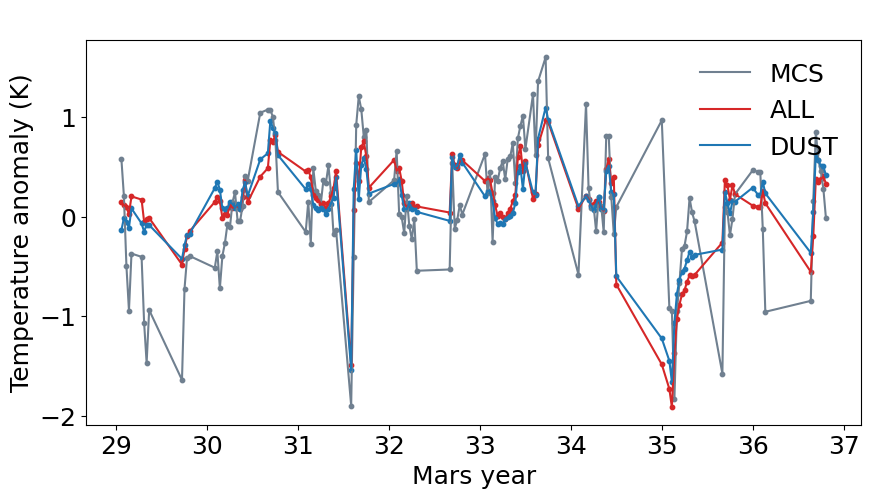

Processing Nighttime Data...


/tmp/ipykernel_16709/3954766472.py:44: FutureWarning: updating coordinate 'sample' with a PandasMultiIndex would leave the multi-index level coordinates ['MY', 'Ls'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['sample', 'MY', 'Ls'])` before assigning new coordinate values.
  da_stacked = da_stacked.assign_coords(sample=continuous_time.values.flatten())


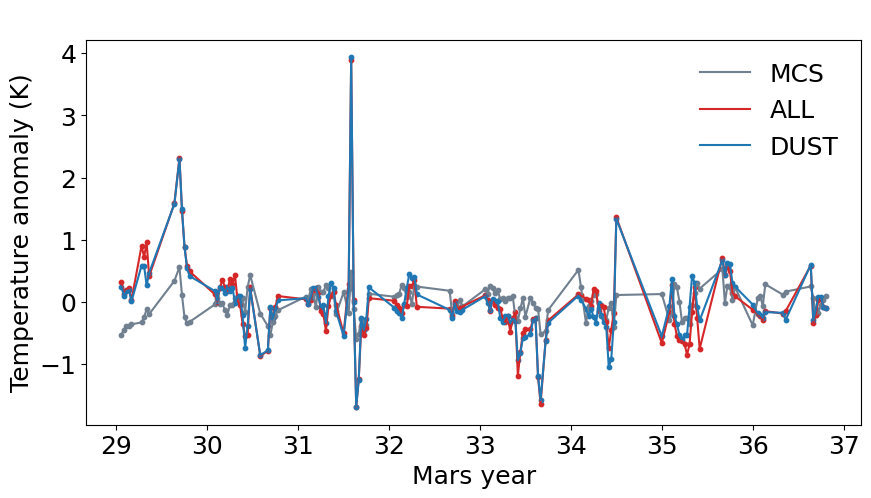

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ==========================================
# Configuration & Constants
# ==========================================
PATHS = {
    'MCS': '../data/MCS_tsurf_corrected.nc',
    'DUST_DAY': '../data/DUST_scenario_day.nc',
    'ALL_DAY': '../data/ALL_scenario_day.nc',
    'DUST_NIGHT': '../data/DUST_scenario_night.nc',
    'ALL_NIGHT': '../data/ALL_scenario_night.nc'
}

PARAMS = {
    'my_start': 29,
    'my_end': 36,
    'lat_bounds': slice(-60, 60),
    'ltst_day': 15,
    'ltst_night': 3
}

# ==========================================
# Data Processing Functions
# ==========================================

def weight_mean(data):
    """Calculates latitude-weighted mean."""
    weights = np.cos(np.deg2rad(data.Lat))
    weights.name = "weights"
    tsurf_weighted = data.weighted(weights)
    return tsurf_weighted.mean(("Lat", "Lon"))

def cal_continuous_time(da: xr.DataArray) -> xr.DataArray:
    """Convert Mars Year (MY) and Ls into a single continuous time coordinate."""
    # Calculate continuous fractional MY
    continuous_time = da.coords["MY"] + da.coords["Ls"] / 360.0
    
    # Stack dimensions to flatten the time series
    da_stacked = da.stack(sample=("MY", "Ls"))
    
    # Assign the new coordinate and rename for clarity
    da_stacked = da_stacked.assign_coords(sample=continuous_time.values.flatten())
    da_stacked = da_stacked.rename({"sample": "MY"})
    
    return da_stacked

def process_mcs_data(ds_mcs, ltst, params):
    """
    Extracts MCS data, calculates climatology, anomalies, and applies filtering.
    """
    # 1. Selection
    ds_mcs_tmean = ds_mcs['tsurf_correct'].loc[
        params['my_start']:params['my_end'], :, ltst, params['lat_bounds']
    ]

    # 2. Filter specific MY34 dust storm event
    mask_storm = (ds_mcs_tmean.MY == 34) & (ds_mcs_tmean.Ls > 180) & (ds_mcs_tmean.Ls < 250)
    ds_mcs_tmean = ds_mcs_tmean.where(~mask_storm)

    # 3. Calculate Climatology and Anomaly
    ds_mcs_tmean_clim = ds_mcs_tmean.loc[params['my_start']:params['my_end']].mean(dim='MY')
    ds_mcs_tmean_anom = ds_mcs_tmean - ds_mcs_tmean_clim

    # 4. Convert to Continuous Time
    ds_mcs_3d_tmean_anom = cal_continuous_time(ds_mcs_tmean_anom)

    # 5. Spatial Coverage Filter (count > 800)
    valid_count_mask = ds_mcs_3d_tmean_anom.where(ds_mcs_3d_tmean_anom).count(dim=('Lat', 'Lon')) > 800
    da_mcs_anom_3d_new = ds_mcs_3d_tmean_anom.where(valid_count_mask)

    # 6. Weighted Mean
    ds_final = weight_mean(da_mcs_anom_3d_new)

    # 7. Outlier Filter (2 standard deviations)
    std_mask = np.abs(ds_final) < 2 * ds_final.std()
    ds_final = ds_final.where(std_mask).dropna(dim='MY')

    return ds_final

# ==========================================
# Plotting Helper Functions
# ==========================================

def modify_plot(ax):
    ax.tick_params(labelsize=18)

def set_title(ax, title='', label_x='', label_y=''):
    ax.set_title(title, loc='center', fontdict={'size': 20})
    ax.set_xlabel(label_x, fontdict={'size': 18})
    ax.set_ylabel(label_y, fontdict={'size': 18})

def modify_main(ax):
    modify_plot(ax)
    set_title(ax, title=' ', label_x='Mars year', label_y='Temperature anomaly (K)')

def make_plot(mcs_data, all_data, dust_data):
    """Generates the figure based on processed datasets."""
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot MCS
    ax.plot(mcs_data.MY.values, mcs_data.values, c='slategrey', label='MCS')
    ax.scatter(mcs_data.MY.values, mcs_data.values, c='slategrey', s=10)

    # Plot ALL Scenario
    ax.plot(all_data.MY.values, all_data.values, c='tab:red', label='ALL')
    ax.scatter(all_data.MY.values, all_data.values, c='tab:red', s=10)

    # Plot DUST Scenario
    ax.plot(dust_data.MY.values, dust_data.values, c='tab:blue', label='DUST') 
    ax.scatter(dust_data.MY.values, dust_data.values, c='tab:blue', s=10)

    # Styling
    ax.legend(prop={'size': 18}, frameon=False, loc='upper right', ncol=1)
    modify_main(ax)
    
    return fig, ax

# ==========================================
# Main Execution
# ==========================================

if __name__ == "__main__":
    # Load MCS Data once
    ds_mcs = xr.open_dataset(PATHS['MCS'])

    # --- Process 1: Daytime (LTST 15) ---
    print("Processing Daytime Data...")
    mcs_day = process_mcs_data(ds_mcs, PARAMS['ltst_day'], PARAMS)
    
    # Load comparison data for Day
    tsurf_dust_day = xr.open_dataset(PATHS['DUST_DAY'])['tsurf']
    tsurf_all_day = xr.open_dataset(PATHS['ALL_DAY'])['tsurf']
    
    # Plot Day
    fig_day, ax_day = make_plot(mcs_day, tsurf_all_day, tsurf_dust_day)
    plt.show()

    # --- Process 2: Nighttime (LTST 3) ---
    print("Processing Nighttime Data...")
    mcs_night = process_mcs_data(ds_mcs, PARAMS['ltst_night'], PARAMS)
    
    # Load comparison data for Night
    tsurf_dust_night = xr.open_dataset(PATHS['DUST_NIGHT'])['tsurf']
    tsurf_all_night = xr.open_dataset(PATHS['ALL_NIGHT'])['tsurf']
    
    # Plot Night
    fig_night, ax_night = make_plot(mcs_night, tsurf_all_night, tsurf_dust_night)
    plt.show()